# Analysis of SEIRX model runs for test technology and screening frequency

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import analysis_functions as af

In [5]:
language = 'english' # English or German

In [17]:
# get the right plot labels given the language
metric_name_map = af.label_map[language]['metric_name_map']
frequency_name_map = af.label_map[language]['frequency_name_map']
test_name_map = af.label_map[language]['test_name_map']
index_case_map = af.label_map[language]['index_case_map']
xlabel = af.label_map[language]['xlabels']['testing_strategy']
ylabel = af.label_map[language]['ylabels']['testing_strategy']

if language == 'english':
    screening_intervals = ['never', 'once\na week', 'twice\na week', 
                           '3 times\na week']
if language == 'german':
    screening_intervals = ['nie', 'ein mal\npro Woche', '2 mal\npro Woche',
                           '3 mal\npro Woche']

## Analysis B.1.1.7

### Data loading and wrangling

In [8]:
res_path = '../data/simulation_results'
dst_path = '../plots/'
sim_name = 'simulations_testing_strategy'
N_runs = 5000
data = pd.read_csv(join(res_path,'{}_UK_variant_{}.csv'.format(sim_name, N_runs)))

In [9]:
# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

# set screen intervals, test types and index case as categorical variables with
# explicit order, to facilitate sorting in a nicer way
data['resident_screen_interval'] = pd.Categorical(data['resident_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['employee_screen_interval'] = pd.Categorical(data['employee_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['test_type'] = pd.Categorical(data['test_type'], 
    categories=['same_day_antigen', 'same_day_LAMP', 'same_day_PCR', 'one_day_PCR',  
                'two_day_PCR',], ordered=True)

data['index_case'] = pd.Categorical(data['index_case'], 
    categories=['employee', 'resident'], ordered=True)

data = data.sort_values(by=['test_type', 'employee_screen_interval', 
                            'resident_screen_interval', 'index_case'],
                       ascending=True)

data = data.set_index(['test_type', 'employee_screen_interval', 
                       'resident_screen_interval', 'index_case'])

### Different test technologies

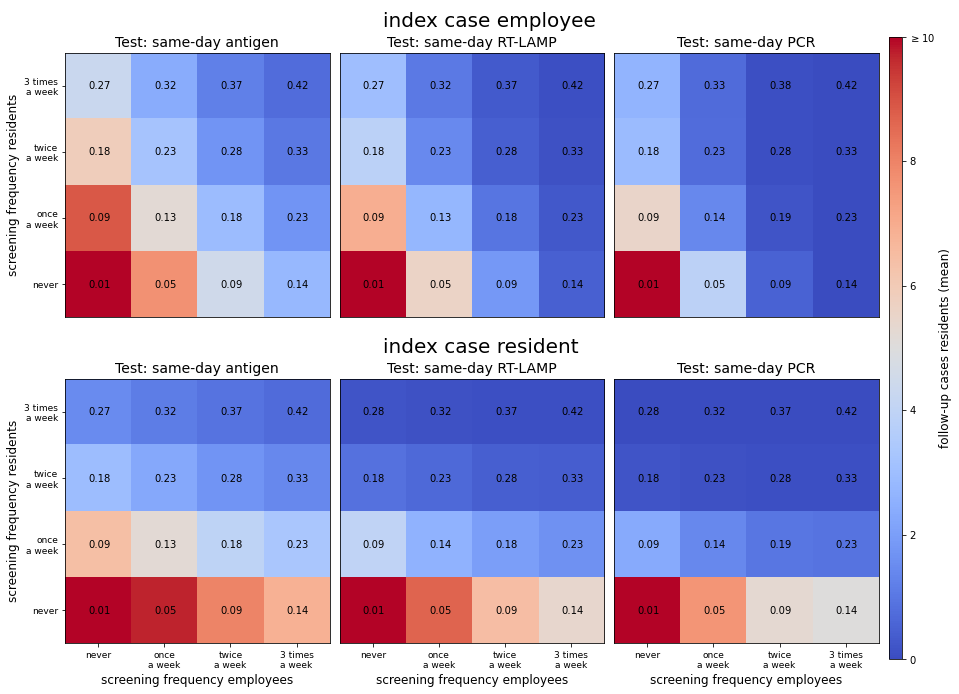

In [18]:
metric = 'infected_residents_mean'
sim_name = 'simulation_results'
screening_params = screening_intervals

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin=0
vmax=10
vstep=2

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # remove all axis labels and ticks for the heatmaps
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
        
    j = 0
    # compare same-day turnover testing for different testing technologies
    for j, ax, test_type in zip(range(3), hmap_axes[i],\
                       ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']):
        
        # set flag to set axis ticks only for heatmaps at the boundaries of 
        # the figure
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the testing technology in the heatmap title
        ax.set_title('Test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df, test_type, screening_params, metric)
        if index_case_mode == 'resident':
            # if a resident is the index case, we need to subtract 1 from the
            # number of infected residents, to calculate the "outbreak size",
            # which is defined as the number of FOLLOW-UP cases, given an index
            # case
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax,
                                   xticks, yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df, test_type, screening_params, 
                                    'test_rate_mean')
        af.annotate_heatmap(ax, test_rate)
        
# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                        ticks=np.arange(vmin, vmax + 1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path,
            'screening_frequency_test_technology_UK_variant_{}.png'\
            .format(language[0:3])), dpi=300, transparent=True)
plt.savefig(join(dst_path, 
            'screening_frequency_test_technology_UK_variant_{}.pdf'\
            .format(language[0:3])), transparent=True)

### PCR: different turnover times

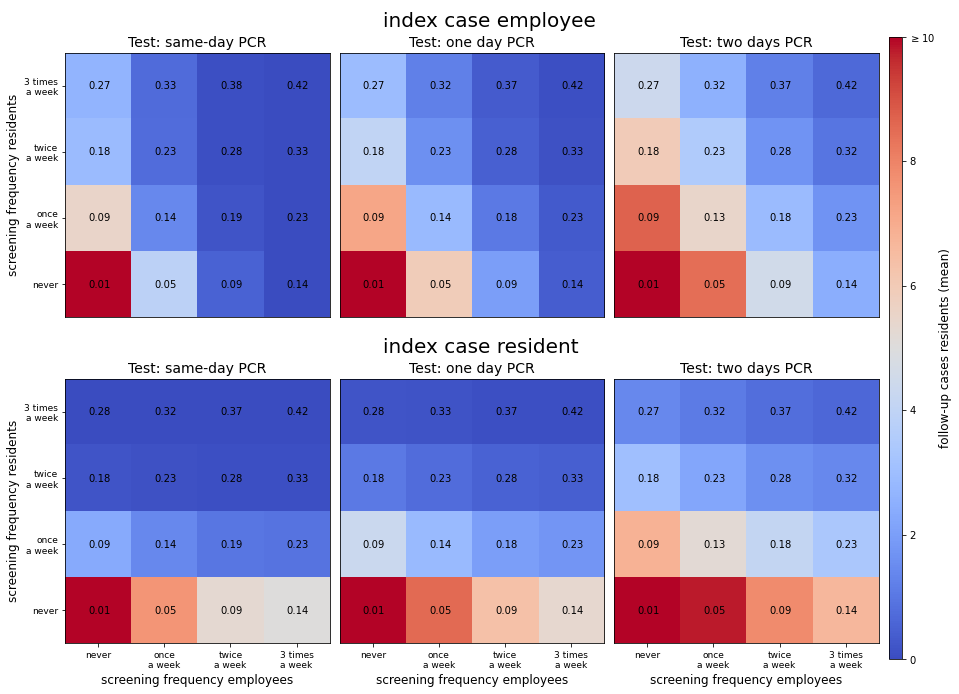

In [19]:
metric = 'infected_residents_mean'
sim_name = 'simulation_results'
screening_params = screening_intervals

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 10
vstep = 2

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # set flag to set axis ticks only for heatmaps at the boundaries of 
    # the figure
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
    
    # compare different test result turnover times for PCR tests
    for j, ax, test_type in zip(range(3), hmap_axes[i], \
                        ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']):
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the turnover time in the heatmap title
        ax.set_title('Test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df, test_type, screening_params, metric)
        if index_case_mode == 'resident':
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax,
                                   xticks, yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df, test_type, screening_params, 
                                    'test_rate_mean')
        af.annotate_heatmap(ax, test_rate)

# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                ticks=np.arange(vmin, vmax+1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 
            'screening_frequency_PCR_turnover_time_UK_variant_{}.png'\
            .format(language[0:3])), dpi=300, transparent=True)
plt.savefig(join(dst_path,
            'screening_frequency_PCR_turnover_time_UK_variant_{}.pdf'\
            .format(language[0:3])))

### Outbreak sizes

**Note**: for resident index cases, the index case needs to be subtracted from the outbreak size

#### Minimum and maximum

In [20]:
data['infected_residents_mean'].idxmin()

('same_day_PCR', '3 times\na week', '3 times\na week', 'employee')

In [21]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_mean']

0.0

In [22]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_std']

0.0

Note: for every test type, there is a scenario where neither employees nor residents are screened. These scenarios are, naturally, the ones with the largest outbreaks. To calculate the outbreak sizes of the largest outbreaks, we therefore average outbreak sizes of all these scenarios:

In [23]:
mean = (data.loc[:, 'never', 'never', 'resident']['infected_residents_mean'] - 1).mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'resident']['infected_residents_std']**2).mean())
print('{} +- {}'.format(mean, std))

11.896959999999998 +- 11.396771936040153


In [24]:
mean = (data.loc[:, 'never', 'never', 'employee']['infected_residents_mean']).mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'employee']['infected_residents_std']**2).mean())
print('{} +- {}'.format(mean, std))

12.361600000000001 +- 11.78959266213332


#### Realistic scenario I: employees screened 2x / week

##### Same-day LAMP

In [25]:
# employee index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.8742 +- 5.242544345472229


In [26]:
# resident index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.483 +- 7.817668078579274


##### One-day PCR

In [27]:
# employee index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.9932 +- 5.270930686516415


In [28]:
# resident index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.3346 +- 7.742521047206349


##### Same-day Antigen

In [29]:
# employee index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

4.5276 +- 7.952451605467805


In [30]:
# resident index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

8.0038 +- 8.925318919991863


##### Same-day PCR

In [31]:
# employee index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.5202 +- 2.7129069156140537


In [32]:
# resident index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.2848 +- 6.868094575981094


##### Two-day PCR

In [33]:
# employee index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

4.5382 +- 7.83295677266002


In [34]:
# resident index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

7.816000000000001 +- 8.840326593223521


#### Realistic scenario II: employees screened 1x / week

##### Same-day PCR

In [35]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.893 +- 7.464093618029435


In [36]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

7.585800000000001 +- 8.699504275240457


##### Same-day LAMP

In [37]:
# employee index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.6156 +- 8.840535484546775


In [38]:
# resident index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

8.667 +- 9.438428247624554


##### Same-day Antigen

In [39]:
# employee index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

7.674 +- 10.059859052334213


In [40]:
# resident index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

9.7012 +- 10.187260407730973


#### Two-day PCR

##### Employees 3x / week, residents never 

In [41]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.4948 +- 5.823603337381954


In [42]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.67 +- 8.039802714341759


##### Employees 3x / week, residents 1x / week 

In [43]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.7168 +- 4.228590067007082


In [44]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.3926 +- 5.184963067216746


##### Employees 3x / week, residents 2x / week 

In [45]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.9764 +- 2.4122617688319554


In [46]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.4104 +- 2.6920292056827413


##### Employees 3x / week, residents 3x / week 

In [47]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6922 +- 1.556516530185834


In [48]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6544000000000001 +- 1.4354695240759765


#### Same-day PCR

In [49]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.4212 +- 2.962084628951343


In [50]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.4152 +- 2.901188090846178


### Test rates

#### Diagnostic testing base rate

In [51]:
mean = data.loc[:, 'never', 'never', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.006939065813048799 +- 0.0052578742713192145


In [52]:
mean = data.loc[:, 'never', 'never', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.006855398855333759 +- 0.005237219992395677


#### Test rates employeed screened 2x / week

In [53]:
mean = data.loc[:, 'twice\na week', 'never', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'twice\na week', 'never', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.09226878115597573 +- 0.01170942322284395


In [54]:
mean = data.loc[:, 'twice\na week', 'never', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'twice\na week', 'never', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.09256821321115057 +- 0.010800683670373389


#### Test rates residents screened 2x / week

In [55]:
mean = data.loc[:, 'never', 'twice\na week', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'twice\na week', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.17990885743168564 +- 0.01982936384649848


In [56]:
mean = data.loc[:, 'never', 'twice\na week', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'twice\na week', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.18192611796656316 +- 0.022439251104291284


In [57]:
mean = data.loc[:, 'never', 'twice\na week', :]['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'twice\na week', :]['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.18091748769912439 +- 0.02117455620170419


#### Test rates residents screened 3x / week

In [58]:
mean = data.loc[:, 'never', '3 times\na week', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', '3 times\na week', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.27225189597933047 +- 0.022225708234275037


In [59]:
mean = data.loc[:, 'never', '3 times\na week', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', '3 times\na week', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.27634463374337553 +- 0.02346177866051484


In [60]:
mean = data.loc[:, 'never', '3 times\na week', :]['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', '3 times\na week', :]['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.27429826486135295 +- 0.02285210235875586


### False negatives

In [61]:
data.loc['same_day_antigen'][['undetected_infections_mean', 'undetected_infections_std']]

undetected_infections_mean  \
employee_screen_interval resident_screen_interval index_case                               
3 times\na week          3 times\na week          employee                        0.0892   
                                                  resident                        0.0926   
                         twice\na week            employee                        0.1070   
                                                  resident                        0.1384   
                         once\na week             employee                        0.1436   
                                                  resident                        0.2088   
                         never                    employee                        0.0974   
                                                  resident                        0.1474   
twice\na week            3 times\na week          employee                        0.1120   
                                                  resident                        0.1006   
                         twice\na week            employee                        0.1422   
                                                  resident                        0.1482   
                         once\na week             employee                        0.2086   
                                                  resident                        0.2606   
                         never                    employee                        0.1290   
                                                  resident                        0.1538   
once\na week             3 times\na week          employee                        0.1682   
                                                  resident                        0.1014   
                         twice\na week            employee                        0.2010   
                                                  resident                        0.1882   
                         once\na week             employee                        0.2762   
                                                  resident                        0.2936   
                         never                    employee                        0.1354   
                                                  resident                        0.1324   
never                    3 times\na week          employee                        0.1972   
                                                  resident                        0.1132   
                         twice\na week            employee                        0.2596   
                                                  resident                        0.1984   
                         once\na week             employee                        0.3656   
                                                  resident                        0.2894   
                         never                    employee                        0.0000   
                                                  resident                        0.0000   

                                                              undetected_infections_std  
employee_screen_interval resident_screen_interval index_case                             
3 times\na week          3 times\na week          employee                     0.318219  
                                                  resident                     0.316931  
                         twice\na week            employee                     0.387274  
                                                  resident                     0.411436  
                         once\na week             employee                     0.454115  
                                                  resident                     0.558270  
                         never                    employee                     0.338136  
                                                  resident                     0.416303  
twice\na week            3 times\

### Results table

#### Employee index case

In [65]:
table_data = data.loc[:,:,:,'employee'].copy()
table_data = table_data.loc[:, :, ['never', 'once\na week']]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])


table_data = table_data.reset_index()

table_data['employee_screen_interval'] =  \
    table_data['employee_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['resident_screen_interval'] =  \
    table_data['resident_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['infected_residents_median_10_90'] = \
    ['{} [{}; {}]'.format(median, ten, ninety) for \
    median, ten, ninety in zip(\
                round(table_data['infected_residents_median']),
                round(table_data['infected_residents_0.10']),
                round(table_data['infected_residents_0.90']))]

table_data['infected_residents_mean_std'] = \
    ['{:1.1f} ± {:1.1f}'.format(mean, af.round_decimals_up(std, 1)) for \
    mean, std in zip(\
    round(table_data['infected_residents_mean'], 1),
    table_data['infected_residents_std'])]

table_data['R0_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['R0_mean'], 2),
    table_data['R0_std'])]

table_data['test_rate_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['test_rate_mean'], 2),
    table_data['test_rate_std'])]

table_cols = ['test_type','employee_screen_interval', 'resident_screen_interval',
              'infected_residents_mean_std', 'infected_residents_median_10_90',
              'R0_mean_std', 'test_rate_mean_std']

In [66]:
table_path = '../data/results_tables'
table_data = table_data[table_cols]
table_data.to_csv(join(table_path, 'table_testing_strategy_UK_variant_employee.csv'))

#### Resident index case

In [67]:
table_data = data.loc[:,:,:,'resident'].copy()
table_data = table_data.loc[:, :, ['never', 'once\na week']]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])


table_data = table_data.reset_index()

table_data['employee_screen_interval'] =  \
    table_data['employee_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['resident_screen_interval'] =  \
    table_data['resident_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['infected_residents_median_10_90'] = \
    ['{} [{}; {}]'.format(median, ten, ninety) for \
    median, ten, ninety in zip(\
                round(table_data['infected_residents_median']),
                round(table_data['infected_residents_0.10']),
                round(table_data['infected_residents_0.90']))]

table_data['infected_residents_mean_std'] = \
    ['{:1.1f} ± {:1.1f}'.format(mean, af.round_decimals_up(std, 1)) for \
    mean, std in zip(\
    round(table_data['infected_residents_mean'], 1),
    table_data['infected_residents_std'])]

table_data['R0_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['R0_mean'], 2),
    table_data['R0_std'])]

table_data['test_rate_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['test_rate_mean'], 2),
    table_data['test_rate_std'])]

table_cols = ['test_type','employee_screen_interval', 'resident_screen_interval',
              'infected_residents_mean_std', 'infected_residents_median_10_90',
              'R0_mean_std', 'test_rate_mean_std']

In [68]:
table_data = table_data[table_cols]
table_data.to_csv(join(table_path, 'table_testing_strategy_UK_variant_resident.csv'))

### Preventive testing rates

In [69]:
data.loc[:,'3 times\na week', 'never', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.138848       0.013075
                 resident          0.137883       0.013794
same_day_LAMP    employee          0.140944       0.012078
                 resident          0.138661       0.013466
same_day_PCR     employee          0.140891       0.011833
                 resident          0.138971       0.012811
one_day_PCR      employee          0.140483       0.012018
                 resident          0.138552       0.013591
two_day_PCR      employee          0.137808       0.013624
                 resident          0.135964       0.015397

In [70]:
data.loc[:,'never', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.271507       0.023331
                 resident          0.274296       0.022507
same_day_LAMP    employee          0.273480       0.020531
                 resident          0.278252       0.023498
same_day_PCR     employee          0.274693       0.020621
                 resident          0.278323       0.024087
one_day_PCR      employee          0.273539       0.021024
                 resident          0.277627       0.023549
two_day_PCR      employee          0.268041       0.025236
                 resident          0.273225       0.023638

In [71]:
data.loc[:,'3 times\na week', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.420970       0.031422
                 resident          0.421056       0.031474
same_day_LAMP    employee          0.423438       0.035948
                 resident          0.422764       0.035709
same_day_PCR     employee          0.422953       0.036349
                 resident          0.422463       0.035692
one_day_PCR      employee          0.421938       0.035682
                 resident          0.422409       0.034934
two_day_PCR      employee          0.419571       0.033314
                 resident          0.420003       0.032297

## Analysis wild type

### Data loading and wrangling

In [72]:
res_path = '../data/simulation_results'
dst_path = '../plots/'
sim_name = 'simulations_testing_strategy'
N_runs = 5000
data = pd.read_csv(join(res_path,'{}_{}.csv'.format(sim_name, N_runs)))

In [73]:
# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

# set screen intervals, test types and index case as categorical variables with
# explicit order, to facilitate sorting in a nicer way
data['resident_screen_interval'] = pd.Categorical(data['resident_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['employee_screen_interval'] = pd.Categorical(data['employee_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['test_type'] = pd.Categorical(data['test_type'], 
    categories=['same_day_antigen', 'same_day_LAMP', 'same_day_PCR', 'one_day_PCR',  
                'two_day_PCR',], ordered=True)

data['index_case'] = pd.Categorical(data['index_case'], 
    categories=['employee', 'resident'], ordered=True)

data = data.sort_values(by=['test_type', 'employee_screen_interval', 
                            'resident_screen_interval', 'index_case'],
                       ascending=True)

data = data.set_index(['test_type', 'employee_screen_interval', 
                       'resident_screen_interval', 'index_case'])

### Different test technologies

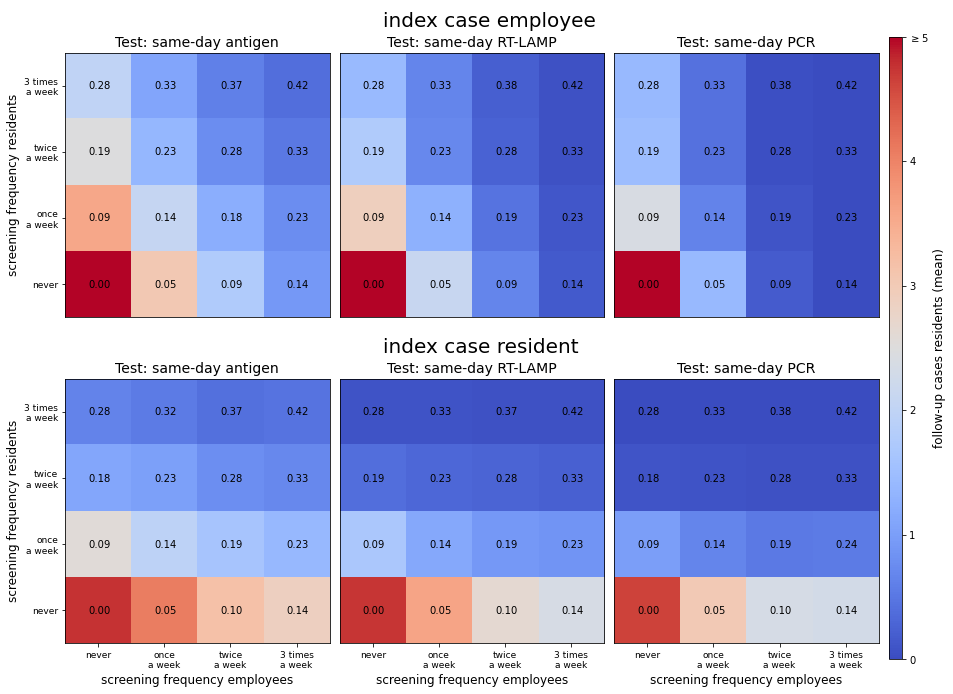

In [74]:
metric = 'infected_residents_mean'
sim_name = 'simulation_results'
screening_params = screening_intervals

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin=0
vmax=5
vstep=1

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # remove all axis labels and ticks for the heatmaps
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
        
    j = 0
    # compare same-day turnover testing for different testing technologies
    for j, ax, test_type in zip(range(3), hmap_axes[i],\
                       ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']):
        
        # set flag to set axis ticks only for heatmaps at the boundaries of 
        # the figure
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the testing technology in the heatmap title
        ax.set_title('Test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df, test_type, screening_params, metric)
        if index_case_mode == 'resident':
            # if a resident is the index case, we need to subtract 1 from the
            # number of infected residents, to calculate the "outbreak size",
            # which is defined as the number of FOLLOW-UP cases, given an index
            # case
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax,
                                   xticks, yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df, test_type, screening_params, 
                                    'test_rate_mean')
        af.annotate_heatmap(ax, test_rate)
        
# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                        ticks=np.arange(vmin, vmax + 1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 'screening_frequency_test_technology_{}.png'\
                .format(language[0:3])), dpi=300, transparent=True)
plt.savefig(join(dst_path, 'screening_frequency_test_technology_{}.pdf'\
                .format(language[0:3])), transparent=True)

### PCR: different turnover times

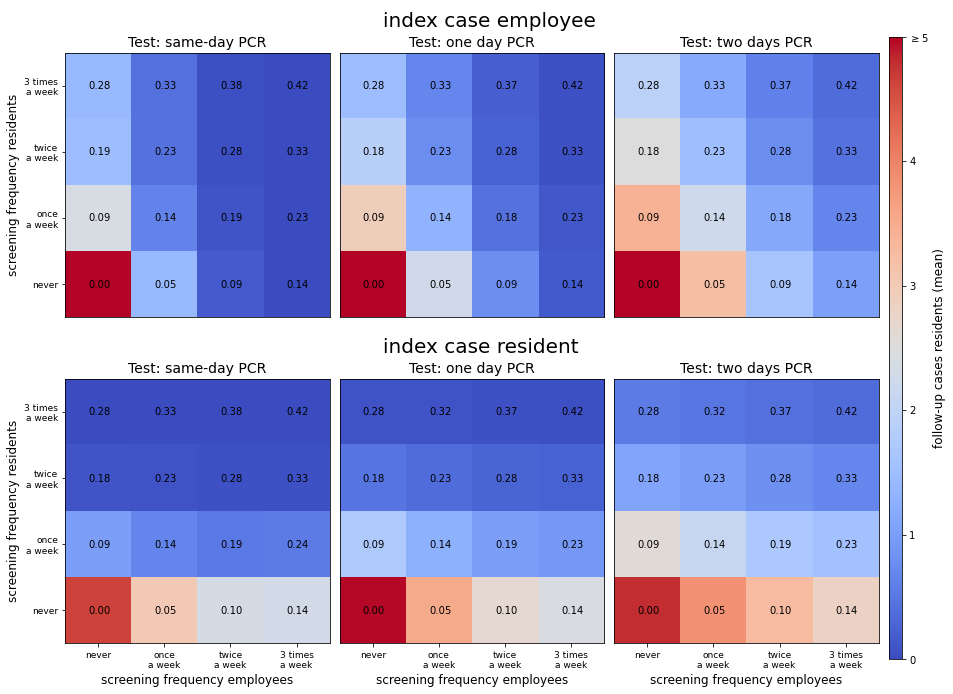

In [75]:
metric = 'infected_residents_mean'
sim_name = 'simulation_results'
screening_params = screening_intervals

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 5
vstep = 1

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # set flag to set axis ticks only for heatmaps at the boundaries of 
    # the figure
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
    
    # compare different test result turnover times for PCR tests
    for j, ax, test_type in zip(range(3), hmap_axes[i], \
                        ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']):
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the turnover time in the heatmap title
        ax.set_title('Test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df, test_type, screening_params, metric)
        if index_case_mode == 'resident':
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax,
                                   xticks, yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df, test_type, screening_params, 
                                    'test_rate_mean')
        af.annotate_heatmap(ax, test_rate)

# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                ticks=np.arange(vmin, vmax+1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 'screening_frequency_PCR_turnover_time_{}.png'\
                .format(language[0:3])), dpi=300, transparent=True)
plt.savefig(join(dst_path, 'screening_frequency_PCR_turnover_time_{}.pdf'\
                .format(language[0:3])))

### Outbreak sizes

**Note**: for resident index cases, the index case needs to be subtracted from the outbreak size

#### Minimum and maximum

In [62]:
data['infected_residents_mean'].idxmin()

('same_day_PCR', '3 times\na week', '3 times\na week', 'employee')

In [63]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_mean']

0.0

In [64]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_std']

0.0

#### Realistic scenario I: employees screened 2x / week

##### Same-day Antigen

In [65]:
# employee index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.7722 +- 3.969465769054866


In [66]:
# resident index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.1654 +- 4.789470810656353


##### Same-day LAMP

In [67]:
# employee index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6674 +- 2.323931447240709


In [68]:
# resident index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.6388 +- 4.112434435148684


##### One-day PCR

In [69]:
# employee index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.7964 +- 2.6202137592243893


In [70]:
# resident index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.6718 +- 4.219673670934499


##### Same-day PCR

In [71]:
# employee index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.1782 +- 1.2336730319780709


In [72]:
# resident index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.3536 +- 3.781828590179241


##### Two-day PCR

In [73]:
# employee index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.63 +- 3.813555905153135


In [74]:
# resident index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.2748 +- 4.907474057019972


#### Realistic scenario II: employees screened 1x / week

##### Same-day PCR

In [75]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.4098 +- 3.5648850810549595


In [76]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.0271999999999997 +- 4.606550143094522


##### Same-day LAMP

In [77]:
# employee index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.1286 +- 4.516120138816244


In [78]:
# resident index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.6026 +- 5.305836750289642


##### Same-day Antigen

In [79]:
# employee index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.042 +- 5.435121351802714


In [80]:
# resident index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

4.0696 +- 5.786454220892972


#### Two-day PCR

##### Employees 3x / week, residents never 

In [81]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.0166 +- 2.949790618491181


In [82]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.824 +- 4.36605502568365


##### Employees 3x / week, residents 1x / week 

In [83]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6734 +- 2.011552064536652


In [84]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.5779999999999998 +- 2.72884688486991


##### Employees 3x / week, residents 2x / week 

In [85]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.4414 +- 1.2504714214068031


In [86]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6946000000000001 +- 1.5008602054392854


##### Employees 3x / week, residents 3x / week 

In [87]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.358 +- 0.9037695280722704


In [88]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.3675999999999999 +- 0.8992396601536649


#### Same-day PCR

In [89]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6576 +- 1.5662863373528213


In [90]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6659999999999999 +- 1.5419855848576474


### Test rates

#### Diagnostic testing base rate

In [91]:
data.loc[:, 'never', 'never', :]['test_rate_mean'].mean()

0.00384403918343115

In [92]:
data.loc[:, 'never', 'never', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.003238
                  resident      0.003095
same_day_LAMP     employee      0.003183
                  resident      0.003138
same_day_PCR      employee      0.003110
                  resident      0.003107
one_day_PCR       employee      0.003168
                  resident      0.003209
two_day_PCR       employee      0.003153
                  resident      0.003115
Name: test_rate_std, dtype: float64

#### Test rates employeed screened 2x / week

In [93]:
data.loc[:, 'twice\na week', 'never', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.093707
                  resident      0.096077
same_day_LAMP     employee      0.094168
                  resident      0.096021
same_day_PCR      employee      0.093965
                  resident      0.096239
one_day_PCR       employee      0.093652
                  resident      0.095733
two_day_PCR       employee      0.093265
                  resident      0.095109
Name: test_rate_mean, dtype: float64

In [94]:
data.loc[:, 'twice\na week', 'never', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.010428
                  resident      0.009697
same_day_LAMP     employee      0.011639
                  resident      0.009671
same_day_PCR      employee      0.012264
                  resident      0.009419
one_day_PCR       employee      0.011442
                  resident      0.009896
two_day_PCR       employee      0.010906
                  resident      0.009994
Name: test_rate_std, dtype: float64

#### Test rates residents screened 2x / week

In [95]:
data.loc[:, 'never', 'twice\na week', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.185081
                  resident      0.183678
same_day_LAMP     employee      0.185649
                  resident      0.185242
same_day_PCR      employee      0.186095
                  resident      0.184218
one_day_PCR       employee      0.184735
                  resident      0.183843
two_day_PCR       employee      0.183925
                  resident      0.183038
Name: test_rate_mean, dtype: float64

In [96]:
data.loc[:, 'never', 'twice\na week', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.018572
                  resident      0.020855
same_day_LAMP     employee      0.018772
                  resident      0.022342
same_day_PCR      employee      0.018268
                  resident      0.023927
one_day_PCR       employee      0.018202
                  resident      0.022332
two_day_PCR       employee      0.018911
                  resident      0.021317
Name: test_rate_std, dtype: float64

#### Test rates residents screened 3x / week

In [97]:
data.loc[:, 'never', '3 times\na week', :]['test_rate_mean']

test_type         index_case
same_day_antigen  employee      0.278607
                  resident      0.277456
same_day_LAMP     employee      0.279042
                  resident      0.278762
same_day_PCR      employee      0.278889
                  resident      0.278074
one_day_PCR       employee      0.278737
                  resident      0.277923
two_day_PCR       employee      0.277242
                  resident      0.275976
Name: test_rate_mean, dtype: float64

In [98]:
data.loc[:, 'never', '3 times\na week', :]['test_rate_std']

test_type         index_case
same_day_antigen  employee      0.019798
                  resident      0.021322
same_day_LAMP     employee      0.018826
                  resident      0.023012
same_day_PCR      employee      0.019188
                  resident      0.023890
one_day_PCR       employee      0.019365
                  resident      0.023577
two_day_PCR       employee      0.019812
                  resident      0.022298
Name: test_rate_std, dtype: float64

### Results table

#### Employee index case

In [99]:
table_data = data.loc[:,:,:,'employee'].copy()
table_data = table_data.loc[:, :, ['never', 'once\na week']]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])


table_data = table_data.reset_index()

table_data['employee_screen_interval'] =  \
    table_data['employee_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['resident_screen_interval'] =  \
    table_data['resident_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['infected_residents_median_10_90'] = \
    ['{} [{}; {}]'.format(median, ten, ninety) for \
    median, ten, ninety in zip(\
                round(table_data['infected_residents_median']),
                round(table_data['infected_residents_0.10']),
                round(table_data['infected_residents_0.90']))]

table_data['infected_residents_mean_std'] = \
    ['{:1.1f} ± {:1.1f}'.format(mean, af.round_decimals_up(std, 1)) for \
    mean, std in zip(\
    round(table_data['infected_residents_mean'], 1),
    table_data['infected_residents_std'])]

table_data['R0_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['R0_mean'], 2),
    table_data['R0_std'])]

table_data['test_rate_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['test_rate_mean'], 2),
    table_data['test_rate_std'])]

table_cols = ['test_type','employee_screen_interval', 'resident_screen_interval',
              'infected_residents_mean_std', 'infected_residents_median_10_90',
              'R0_mean_std', 'test_rate_mean_std']

In [100]:
table_path = '../data/results_tables'
table_data = table_data[table_cols]
table_data.to_csv(join(table_path, 'table_testing_strategy_employee.csv'))

#### Resident index case

In [101]:
table_data = data.loc[:,:,:,'resident'].copy()
table_data = table_data.loc[:, :, ['never', 'once\na week']]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])


table_data = table_data.reset_index()

table_data['employee_screen_interval'] =  \
    table_data['employee_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['resident_screen_interval'] =  \
    table_data['resident_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['infected_residents_median_10_90'] = \
    ['{} [{}; {}]'.format(median, ten, ninety) for \
    median, ten, ninety in zip(\
                round(table_data['infected_residents_median']),
                round(table_data['infected_residents_0.10']),
                round(table_data['infected_residents_0.90']))]

table_data['infected_residents_mean_std'] = \
    ['{:1.1f} ± {:1.1f}'.format(mean, af.round_decimals_up(std, 1)) for \
    mean, std in zip(\
    round(table_data['infected_residents_mean'], 1),
    table_data['infected_residents_std'])]

table_data['R0_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['R0_mean'], 2),
    table_data['R0_std'])]

table_data['test_rate_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['test_rate_mean'], 2),
    table_data['test_rate_std'])]

table_cols = ['test_type','employee_screen_interval', 'resident_screen_interval',
              'infected_residents_mean_std', 'infected_residents_median_10_90',
              'R0_mean_std', 'test_rate_mean_std']

In [102]:
table_data = table_data[table_cols]
table_data.to_csv(join(table_path, 'table_testing_strategy_resident.csv'))

### Preventive testing rates

In [103]:
data.loc[:,'3 times\na week', 'never', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.141155       0.011407
                 resident          0.143425       0.010600
same_day_LAMP    employee          0.141584       0.012203
                 resident          0.143605       0.010401
same_day_PCR     employee          0.141158       0.012130
                 resident          0.143378       0.010307
one_day_PCR      employee          0.140800       0.011991
                 resident          0.143477       0.010729
two_day_PCR      employee          0.139678       0.011647
                 resident          0.142416       0.011136

In [104]:
data.loc[:,'never', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.278607       0.019798
                 resident          0.277456       0.021322
same_day_LAMP    employee          0.279042       0.018826
                 resident          0.278762       0.023012
same_day_PCR     employee          0.278889       0.019188
                 resident          0.278074       0.023890
one_day_PCR      employee          0.278737       0.019365
                 resident          0.277923       0.023577
two_day_PCR      employee          0.277242       0.019812
                 resident          0.275976       0.022298

In [105]:
data.loc[:,'3 times\na week', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.421883       0.032013
                 resident          0.422001       0.032464
same_day_LAMP    employee          0.423431       0.035060
                 resident          0.423250       0.035601
same_day_PCR     employee          0.422934       0.036567
                 resident          0.423312       0.035929
one_day_PCR      employee          0.422947       0.035773
                 resident          0.422924       0.035489
two_day_PCR      employee          0.420640       0.032849
                 resident          0.421338       0.033812

## Analysis B.1.1.7 & employee masks

### Data loading and wrangling

In [76]:
res_path = '../data/simulation_results'
dst_path = '../plots/'
sim_name = 'simulations_testing_strategy'
N_runs = 5000
data = pd.read_csv(join(res_path,'{}_masks_{}.csv'.format(sim_name, N_runs)))

In [77]:
# replace strings with strings that are nicer for plotting
data['resident_screen_interval'] = data['resident_screen_interval']\
    .replace(frequency_name_map)
data['employee_screen_interval'] = data['employee_screen_interval']\
    .replace(frequency_name_map)

# set screen intervals, test types and index case as categorical variables with
# explicit order, to facilitate sorting in a nicer way
data['resident_screen_interval'] = pd.Categorical(data['resident_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['employee_screen_interval'] = pd.Categorical(data['employee_screen_interval'], 
    categories=['3 times\na week', 'twice\na week', 'once\na week', 'never'],
                      ordered=True)

data['test_type'] = pd.Categorical(data['test_type'], 
    categories=['same_day_antigen', 'same_day_LAMP', 'same_day_PCR', 'one_day_PCR',  
                'two_day_PCR',], ordered=True)

data['index_case'] = pd.Categorical(data['index_case'], 
    categories=['employee', 'resident'], ordered=True)

data = data.sort_values(by=['test_type', 'employee_screen_interval', 
                            'resident_screen_interval', 'index_case'],
                       ascending=True)

data = data.set_index(['test_type', 'employee_screen_interval', 
                       'resident_screen_interval', 'index_case'])

### Different test technologies

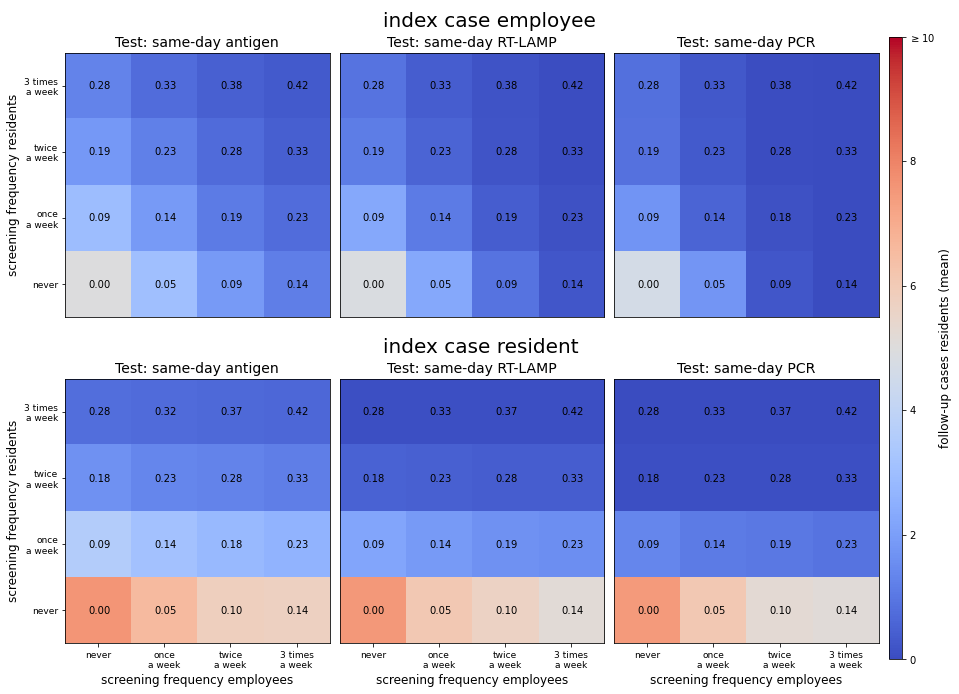

In [78]:
metric = 'infected_residents_mean'
sim_name = 'simulation_results'
screening_params = screening_intervals

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin=0
vmax=10
vstep=2

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # remove all axis labels and ticks for the heatmaps
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
        
    j = 0
    # compare same-day turnover testing for different testing technologies
    for j, ax, test_type in zip(range(3), hmap_axes[i],\
                       ['same_day_antigen', 'same_day_LAMP', 'same_day_PCR']):
        
        # set flag to set axis ticks only for heatmaps at the boundaries of 
        # the figure
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the testing technology in the heatmap title
        ax.set_title('Test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df, test_type, screening_params, metric)
        if index_case_mode == 'resident':
            # if a resident is the index case, we need to subtract 1 from the
            # number of infected residents, to calculate the "outbreak size",
            # which is defined as the number of FOLLOW-UP cases, given an index
            # case
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax,
                                   xticks, yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df, test_type, screening_params, 
                                    'test_rate_mean')
        af.annotate_heatmap(ax, test_rate)
        
# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                        ticks=np.arange(vmin, vmax + 1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path,
            'screening_frequency_test_technology_masks_{}.png'\
            .format(language[0:3])), dpi=300, transparent=True)
plt.savefig(join(dst_path, 
            'screening_frequency_test_technology_masks_{}.pdf'\
            .format(language[0:3])), transparent=True)

### PCR: different turnover times

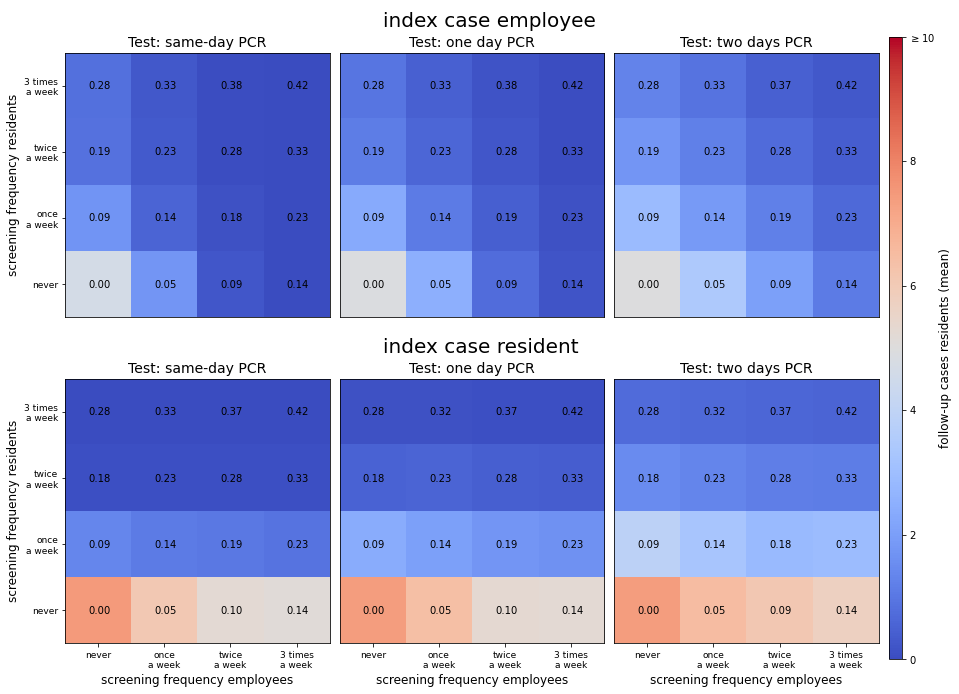

In [79]:
metric = 'infected_residents_mean'
sim_name = 'simulation_results'
screening_params = screening_intervals

# figure layout & axis setup
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(nrows=4, ncols=4, width_ratios=[1,1,1, 0.05],\
                       height_ratios=[0.1,1,0.1,1], wspace=0.05, hspace=0)

title_ax_1 = fig.add_subplot(gs[0, 0:])
hmap_ax_1 = fig.add_subplot(gs[1, 0])
hmap_ax_2 = fig.add_subplot(gs[1, 1])
hmap_ax_3 = fig.add_subplot(gs[1, 2])

title_ax_2 = fig.add_subplot(gs[2, 0:])
hmap_ax_4 = fig.add_subplot(gs[3, 0])
hmap_ax_5 = fig.add_subplot(gs[3, 1])
hmap_ax_6 = fig.add_subplot(gs[3, 2])

cbar_ax = fig.add_subplot(gs[1:, 3])

hmap_axes = [[hmap_ax_1, hmap_ax_2, hmap_ax_3], [hmap_ax_4, hmap_ax_5, hmap_ax_6]]
title_axes = [title_ax_1, title_ax_2]

# possible range of median outbreak sizes to fix the dynamic range of the
# colormaps
vmin = 0
vmax = 10
vstep = 2

# compare scenarios in which either employees or residents are the index case
for i, index_case_mode in enumerate(['employee', 'resident']):
    df = data.loc[:,:,:, index_case_mode]
    
    # set flag to set axis ticks only for heatmaps at the boundaries of 
    # the figure
    t_ax = title_axes[i]
    t_ax.set_xticks([])
    t_ax.set_yticks([])
    t_ax.set_frame_on(False)
    t_ax.set_xlim(0, 1)
    t_ax.set_ylim(0, 3)
    t_ax.text(0.38, 1, index_case_map[index_case_mode], fontsize=20)
    
    # compare different test result turnover times for PCR tests
    for j, ax, test_type in zip(range(3), hmap_axes[i], \
                        ['same_day_PCR', 'one_day_PCR', 'two_day_PCR']):
        xticks = False
        yticks = False
        if i > 0:
            xticks = True
        if j in [0, 3]:
            yticks = True
            
        # put the turnover time in the heatmap title
        ax.set_title('Test: {}'\
                .format(test_name_map[test_type]), fontsize=14)
        
        # plot heatmap of the scenario
        img = af.get_image(df, test_type, screening_params, metric)
        if index_case_mode == 'resident':
            img = img - 1
        img_plot = af.plot_heatmap(ax, img, screening_params, vmin, vmax,
                                   xticks, yticks, xlabel, ylabel)
        
        # annotate heatmap with tests / days / agent
        test_rate = af.get_image(df, test_type, screening_params, 
                                    'test_rate_mean')
        af.annotate_heatmap(ax, test_rate)

# colorbar
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap= plt.get_cmap('coolwarm'), norm=norm)
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical',\
                ticks=np.arange(vmin, vmax+1, vstep))
yticklabels = list(range(vmin, vmax, vstep)) + ['$\geq {}$'.format(vmax)]
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label('{}'.format(metric_name_map[metric]), fontsize=12)      

plt.savefig(join(dst_path, 
            'screening_frequency_PCR_turnover_time_masks_{}.png'\
            .format(language[0:3])), dpi=300, transparent=True)
plt.savefig(join(dst_path,
            'screening_frequency_PCR_turnover_time_masks_{}.pdf'\
            .format(language[0:3])))

### Outbreak sizes

**Note**: for resident index cases, the index case needs to be subtracted from the outbreak size

#### Minimum and maximum

In [80]:
data['infected_residents_mean'].idxmin()

('same_day_PCR', '3 times\na week', '3 times\na week', 'employee')

In [81]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_mean']

0.0

In [82]:
data.loc[data['infected_residents_mean'].idxmin()]['infected_residents_std']

0.0

Note: for every test type, there is a scenario where neither employees nor residents are screened. These scenarios are, naturally, the ones with the largest outbreaks. To calculate the outbreak sizes of the largest outbreaks, we therefore average outbreak sizes of all these scenarios:

In [83]:
mean = (data.loc[:, 'never', 'never', 'resident']['infected_residents_mean'] - 1).mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'resident']['infected_residents_std']**2).mean())
print('{} +- {}'.format(mean, std))

7.481960000000001 +- 8.59902336457838


In [84]:
mean = (data.loc[:, 'never', 'never', 'employee']['infected_residents_mean']).mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'employee']['infected_residents_std']**2).mean())
print('{} +- {}'.format(mean, std))

4.88 +- 7.905411450015667


#### Realistic scenario I: employees screened 2x / week

##### Same-day LAMP

In [85]:
# employee index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.907 +- 3.4974844502150257


In [86]:
# resident index case
mean = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.6592 +- 7.149271135965898


##### One-day PCR

In [87]:
# employee index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.7534 +- 3.145435930588746


In [88]:
# resident index case
mean = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['one_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.2982 +- 6.919888274441007


##### Same-day Antigen

In [89]:
# employee index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.9104 +- 5.06970533881847


In [90]:
# resident index case
mean = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.7886 +- 7.343752186671052


##### Same-day PCR

In [91]:
# employee index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.2456 +- 1.8462833998274737


In [92]:
# resident index case
mean = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.2514 +- 6.788506080350859


##### Two-day PCR

In [93]:
# employee index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.0422 +- 5.29992801907738


In [94]:
# resident index case
mean = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', 'twice\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.1058 +- 7.5226540811661


#### Realistic scenario II: employees screened 1x / week

##### Same-day PCR

In [95]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.7636 +- 4.846814764633835


In [96]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.0652 +- 7.452627542783705


##### Same-day LAMP

In [97]:
# employee index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.3034 +- 5.519550844797578


In [98]:
# resident index case
mean = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_LAMP', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.057 +- 7.554334159468893


##### Same-day Antigen

In [99]:
# employee index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_antigen', 'once\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

3.058 +- 6.39612523983206


In [100]:
# resident index case
mean = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_antigen', 'once\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

6.5888 +- 7.924132314303373


#### Two-day PCR

##### Employees 3x / week, residents never 

In [101]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.1018 +- 3.8276320242916086


In [102]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'never', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

5.7234 +- 7.1195948035006325


##### Employees 3x / week, residents 1x / week 

In [103]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.6792 +- 2.4909292052688152


In [104]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

2.9474 +- 4.533734022727598


##### Employees 3x / week, residents 2x / week 

In [105]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.413 +- 1.4025777856821269


In [106]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', 'twice\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.1518000000000002 +- 2.1976630097767287


##### Employees 3x / week, residents 3x / week 

In [107]:
# employee index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.2794 +- 0.8648035713636991


In [108]:
# resident index case
mean = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['two_day_PCR', '3 times\na week', '3 times\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.5476000000000001 +- 1.233871438905022


#### Same-day PCR

In [109]:
# employee index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_mean']
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'employee']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

0.56 +- 1.5607969814948672


In [110]:
# resident index case
mean = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_mean'] - 1
std = data.loc['same_day_PCR', 'once\na week', 'once\na week', 'resident']\
        ['infected_residents_std']
print('{} +- {}'.format(mean, std))

1.1154000000000002 +- 2.264223527312692


### Test rates

#### Diagnostic testing base rate

In [111]:
mean = data.loc[:, 'never', 'never', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.00350581776586992 +- 0.0031967778673365416


In [112]:
mean = data.loc[:, 'never', 'never', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'never', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.0047934145031279605 +- 0.0037211048507921796


#### Test rates employeed screened 2x / week

In [113]:
mean = data.loc[:, 'twice\na week', 'never', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'twice\na week', 'never', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.09385782007935038 +- 0.011698126251941249


In [114]:
mean = data.loc[:, 'twice\na week', 'never', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'twice\na week', 'never', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.09517150823736208 +- 0.009329423743379802


#### Test rates residents screened 2x / week

In [115]:
mean = data.loc[:, 'never', 'twice\na week', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'twice\na week', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.185968964500018 +- 0.020076288248891027


In [116]:
mean = data.loc[:, 'never', 'twice\na week', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'twice\na week', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.18348589568717286 +- 0.02175250541823251


In [117]:
mean = data.loc[:, 'never', 'twice\na week', :]['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', 'twice\na week', :]['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.18472743009359543 +- 0.020931182979263194


#### Test rates residents screened 3x / week

In [118]:
mean = data.loc[:, 'never', '3 times\na week', 'employee']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', '3 times\na week', 'employee']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.28019831997450795 +- 0.02002088241951969


In [119]:
mean = data.loc[:, 'never', '3 times\na week', 'resident']['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', '3 times\na week', 'resident']['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.27779856710457745 +- 0.022694023823351398


In [120]:
mean = data.loc[:, 'never', '3 times\na week', :]['test_rate_mean'].mean()
std = np.sqrt((data.loc[:, 'never', '3 times\na week', :]['test_rate_std']**2).mean())
print('{} +- {}'.format(mean, std))

0.2789984435395427 +- 0.02139923421703535


### False negatives

In [121]:
data.loc['same_day_antigen'][['undetected_infections_mean', 'undetected_infections_std']]

undetected_infections_mean  \
employee_screen_interval resident_screen_interval index_case                               
3 times\na week          3 times\na week          employee                        0.0610   
                                                  resident                        0.0704   
                         twice\na week            employee                        0.0608   
                                                  resident                        0.1112   
                         once\na week             employee                        0.0840   
                                                  resident                        0.1572   
                         never                    employee                        0.0614   
                                                  resident                        0.0834   
twice\na week            3 times\na week          employee                        0.0676   
                                                  resident                        0.0802   
                         twice\na week            employee                        0.0858   
                                                  resident                        0.1194   
                         once\na week             employee                        0.0984   
                                                  resident                        0.1676   
                         never                    employee                        0.0668   
                                                  resident                        0.0888   
once\na week             3 times\na week          employee                        0.0688   
                                                  resident                        0.0754   
                         twice\na week            employee                        0.0924   
                                                  resident                        0.1194   
                         once\na week             employee                        0.1062   
                                                  resident                        0.1766   
                         never                    employee                        0.0586   
                                                  resident                        0.0652   
never                    3 times\na week          employee                        0.0572   
                                                  resident                        0.0726   
                         twice\na week            employee                        0.0824   
                                                  resident                        0.1204   
                         once\na week             employee                        0.1146   
                                                  resident                        0.1578   
                         never                    employee                        0.0000   
                                                  resident                        0.0000   

                                                              undetected_infections_std  
employee_screen_interval resident_screen_interval index_case                             
3 times\na week          3 times\na week          employee                     0.257084  
                                                  resident                     0.269552  
                         twice\na week            employee                     0.253606  
                                                  resident                     0.367779  
                         once\na week             employee                     0.342005  
                                                  resident                     0.446462  
                         never                    employee                     0.253856  
                                                  resident                     0.297426  
twice\na week            3 times\

### Results table

#### Employee index case

In [122]:
table_data = data.loc[:,:,:,'employee'].copy()
table_data = table_data.loc[:, :, ['never', 'once\na week']]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])


table_data = table_data.reset_index()

table_data['employee_screen_interval'] =  \
    table_data['employee_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['resident_screen_interval'] =  \
    table_data['resident_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['infected_residents_median_10_90'] = \
    ['{} [{}; {}]'.format(median, ten, ninety) for \
    median, ten, ninety in zip(\
                round(table_data['infected_residents_median']),
                round(table_data['infected_residents_0.10']),
                round(table_data['infected_residents_0.90']))]

table_data['infected_residents_mean_std'] = \
    ['{:1.1f} ± {:1.1f}'.format(mean, af.round_decimals_up(std, 1)) for \
    mean, std in zip(\
    round(table_data['infected_residents_mean'], 1),
    table_data['infected_residents_std'])]

table_data['R0_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['R0_mean'], 2),
    table_data['R0_std'])]

table_data['test_rate_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['test_rate_mean'], 2),
    table_data['test_rate_std'])]

table_cols = ['test_type','employee_screen_interval', 'resident_screen_interval',
              'infected_residents_mean_std', 'infected_residents_median_10_90',
              'R0_mean_std', 'test_rate_mean_std']

In [123]:
table_path = '../data/results_tables'
table_data = table_data[table_cols]
table_data.to_csv(join(table_path, 'table_testing_strategy_masks_employee.csv'))

#### Resident index case

In [124]:
table_data = data.loc[:,:,:,'resident'].copy()
table_data = table_data.loc[:, :, ['never', 'once\na week']]\
    .sort_values(by=['test_type', 'employee_screen_interval', 'resident_screen_interval'])


table_data = table_data.reset_index()

table_data['employee_screen_interval'] =  \
    table_data['employee_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['resident_screen_interval'] =  \
    table_data['resident_screen_interval'].replace({\
                        'once\na week':1,
                        'twice\na week':2,
                        '3 times\na week':3})

table_data['infected_residents_median_10_90'] = \
    ['{} [{}; {}]'.format(median, ten, ninety) for \
    median, ten, ninety in zip(\
                round(table_data['infected_residents_median']),
                round(table_data['infected_residents_0.10']),
                round(table_data['infected_residents_0.90']))]

table_data['infected_residents_mean_std'] = \
    ['{:1.1f} ± {:1.1f}'.format(mean, af.round_decimals_up(std, 1)) for \
    mean, std in zip(\
    round(table_data['infected_residents_mean'], 1),
    table_data['infected_residents_std'])]

table_data['R0_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['R0_mean'], 2),
    table_data['R0_std'])]

table_data['test_rate_mean_std'] = \
    ['{:1.2f} ± {:1.2f}'.format(mean, af.round_decimals_up(std, 2)) for \
    mean, std in zip(\
    round(table_data['test_rate_mean'], 2),
    table_data['test_rate_std'])]

table_cols = ['test_type','employee_screen_interval', 'resident_screen_interval',
              'infected_residents_mean_std', 'infected_residents_median_10_90',
              'R0_mean_std', 'test_rate_mean_std']

In [125]:
table_data = table_data[table_cols]
table_data.to_csv(join(table_path, 'table_testing_strategy_masks_resident.csv'))

### Preventive testing rates

In [126]:
data.loc[:,'3 times\na week', 'never', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.141456       0.011875
                 resident          0.141826       0.011003
same_day_LAMP    employee          0.141577       0.012025
                 resident          0.141787       0.010881
same_day_PCR     employee          0.141112       0.012281
                 resident          0.141374       0.010990
one_day_PCR      employee          0.141220       0.012044
                 resident          0.141286       0.011394
two_day_PCR      employee          0.140239       0.011934
                 resident          0.140843       0.011884

In [127]:
data.loc[:,'never', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.280561       0.020920
                 resident          0.277173       0.020847
same_day_LAMP    employee          0.280596       0.019059
                 resident          0.278942       0.023285
same_day_PCR     employee          0.280738       0.019790
                 resident          0.278313       0.024074
one_day_PCR      employee          0.280239       0.019754
                 resident          0.278151       0.023451
two_day_PCR      employee          0.278858       0.020530
                 resident          0.276415       0.021652

In [128]:
data.loc[:,'3 times\na week', '3 times\na week', :][['test_rate_mean', 'test_rate_std']]

test_rate_mean  test_rate_std
test_type        index_case                               
same_day_antigen employee          0.422558       0.033913
                 resident          0.421179       0.031721
same_day_LAMP    employee          0.423023       0.035427
                 resident          0.423335       0.034926
same_day_PCR     employee          0.423562       0.036087
                 resident          0.423695       0.036286
one_day_PCR      employee          0.423118       0.035547
                 resident          0.422177       0.034780
two_day_PCR      employee          0.422025       0.033477
                 resident          0.421055       0.032995